# Assignment 3 Security ML
@author: Filippo Casari \
I run this code on my Macbook Pro M1 on local jupyter notebook

In [11]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy.stats
from tqdm.notebook import tqdm
from multiprocessing import Pool
from functools import partial
from scipy.stats import multivariate_normal
import random
import matplotlib

In [12]:
# AES sbox
sbox = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
])

In [13]:
# Hamming Weight: nr. of 1's in binary of given int value. e.g. HW[0] = 0, HW[255] = 8
HW = np.array([bin(n).count("1") for n in range(0, 256)])
HW

array([0, 1, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 3, 3, 4, 1, 2, 2, 3, 2, 3,
       3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 1, 2, 2, 3, 2, 3, 3, 4, 2, 3, 3, 4,
       3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 1, 2,
       2, 3, 2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5,
       3, 4, 4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5,
       5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 1, 2, 2, 3,
       2, 3, 3, 4, 2, 3, 3, 4, 3, 4, 4, 5, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4,
       4, 5, 4, 5, 5, 6, 2, 3, 3, 4, 3, 4, 4, 5, 3, 4, 4, 5, 4, 5, 5, 6,
       3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 2, 3, 3, 4, 3, 4,
       4, 5, 3, 4, 4, 5, 4, 5, 5, 6, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6,
       5, 6, 6, 7, 3, 4, 4, 5, 4, 5, 5, 6, 4, 5, 5, 6, 5, 6, 6, 7, 4, 5,
       5, 6, 5, 6, 6, 7, 5, 6, 6, 7, 6, 7, 7, 8])

In [14]:
def snr(obs_value, traces):
    max_val = np.max(obs_value)
    means = [None] * (max_val + 1)
    varss = [None] * (max_val + 1)
    for i in range(max_val + 1):
        means[i] = np.mean(traces[obs_value == i], axis=0)
        varss[i] = np.var(traces[obs_value == i], axis=0)
    means = np.array(means)
    varss = np.array(varss)
    snr = np.zeros_like(means[0])
    u_tot = np.mean(means, axis=0)
    v_tot = np.mean(varss, axis=0)
    for i in range(max_val + 1):
        snr += np.power(means[i]-u_tot, 2)
    snr = snr / v_tot
    return snr


# Correlation Power Analysis

In [15]:
with h5py.File('AES_PTv2_Pinata.h5', "r") as in_file:
    pt = np.array(in_file["Pinata/MS1/Attack/MetaData"]['plaintext'])
    key = np.array(in_file["Pinata/MS1/Attack/MetaData"]['key'])
    traces = np.array(in_file["Pinata/MS1/Attack/Traces"])

In [16]:
attack_byte = 2

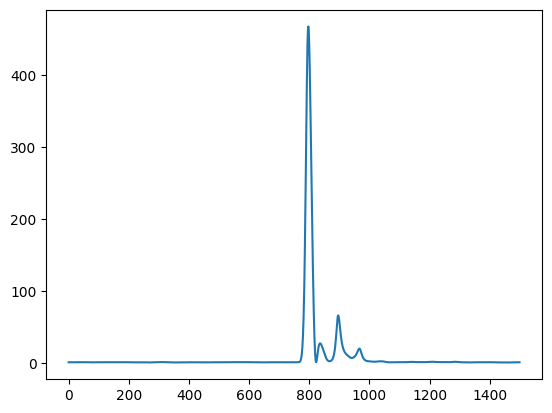

In [17]:
plt.plot(snr(sbox[pt[:,attack_byte]^key[:,attack_byte]], traces))

In [18]:
def partial_key(key_guess, attack_byte, pt, traces): # ^ = XOR
    # xoring plaintext with key guess
    hypotheses = np.array([HW[sbox[pt[i, attack_byte] ^ key_guess]] for i in range(pt.shape[0])])
    # we use the hypotheses and calculate the correlation
    
    return np.max(np.corrcoef(hypotheses, traces, rowvar=False)[0, 1:])

In [19]:
# we have traces, lets take the HW leakage model, now we can do a correlation-based attack
# for this we don't need to use the training dataset, it is an unprofiled attack model

key_vector = np.zeros(256)
print(f"analysing {traces.shape[0]} traces")
print(f"attacking byte {attack_byte}")
for kguess in tqdm(range(256)):
    key_vector[kguess] = partial_key(key_guess=kguess, attack_byte=attack_byte, pt=pt, traces=traces)
    #if(kguess % 64 == 0):
    #    print(key_vector.shape)
print(f"key hypothesis with highest correlation: {np.argmax(key_vector)}, correct key: {key[0][attack_byte]}")

analysing 50000 traces
attacking byte 2


  0%|          | 0/256 [00:00<?, ?it/s]

key hypothesis with highest correlation: 186, correct key: 186


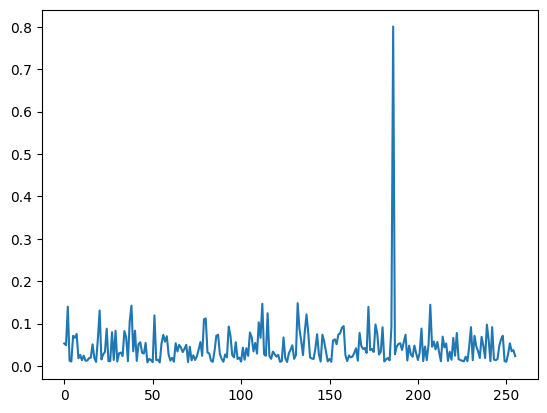

In [20]:
plt.plot(key_vector)

In [ ]:
# with Pool() as pool:
#     key_vector = list(tqdm(pool.imap(partial(partial_key, attack_byte=attack_byte, pt=pt, traces=traces), range(256)), total=256))
# print(f"key hypothesis with highest correlation: {np.argmax(key_vector)}, correct key: {key[0][attack_byte]}")

# Differential Power Analysis

In [ ]:
# exercise: write the code to do a differential power analysis below

In [21]:
# example of pointwise mean
a = np.array([[1,2,3]])
b = np.array([[7,8,9]])
np.mean([a,b], axis=0).flatten()

array([4., 5., 6.])

analysing 50000 traces
attacking byte 2


  0%|          | 0/256 [00:00<?, ?it/s]

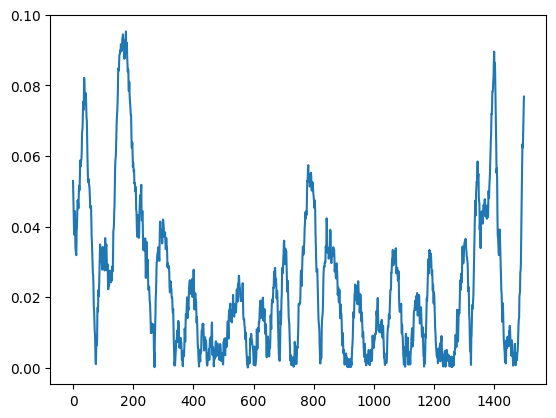

key hypothesis with highest DoM: 186, correct key: 186


In [22]:
key_vector = np.zeros(256)
print(f"analysing {traces.shape[0]} traces")
print(f"attacking byte {attack_byte}")

for kguess in tqdm(range(256)):
    #######
    ####### YOU ONLY NEED TO FILL IN THIS CODE INSIDE THE FOR-LOOP
    #######
    # make the hypotheses of the leaking value based on the key
    
    
    
    hypotheses = np.array([[sbox[pt[i, attack_byte] ^ kguess]] for i in range(pt.shape[0])]) #np.array([])
    #HW = bin(hypotheses)[-1]
    
    lsb_0=[]
    lsb_1=[]
    #print("shape of hypotheses", hypotheses.shape)
    # split the traces into 2 groups based on the LSB of the hypotheses, and calculate the point-wise mean of each
    for i, hyp in enumerate(hypotheses):
        hyp_out = bin(hyp[0])
        last_bit = hyp_out[-1]
        if(last_bit == '0'):
            lsb_0.append(traces[i])
        else:
            lsb_1.append(traces[i])
            
    lsb_0 = np.array(lsb_0)
    lsb_1 = np.array(lsb_1)
    #print("shape of lsb_0", lsb_0.shape)
    lsb_0= np.mean(lsb_0, axis=0)
    lsb_1= np.mean(lsb_1, axis=0)
    
    #print(traces)
        #print(hypotheses)
    
    
    # calculate the point-wise absolute difference between the 2 groups
    diff = np.abs(lsb_0 - lsb_1)
    # estimate the probability / likelihood of this keyguess as the maximum absolute point-wise difference between the groups
    key_vector[kguess] = np.max(diff)
    if(kguess == 0):
        plt.plot(diff)
        plt.show()

print(f"key hypothesis with highest DoM: {np.argmax(key_vector)}, correct key: {key[0][attack_byte]}")

# Template attack
Now we will run a template attack which is a type of profiled attack. It is quite simple in the sense that you build a multivariate normal distribution for each hamming weight. Then in the attacking stage you use these distributions to estimate the likelihood of your hypotheses.

In [23]:
with h5py.File('AES_PTv2_Pinata.h5', "r") as in_file:
    traces_prof = np.array(in_file["Pinata/Unprotected/Profiling/Traces"])
    traces_attack = np.array(in_file["Pinata/Unprotected/Attack/Traces"])
    
    pt_prof = np.array(in_file["Pinata/Unprotected/Profiling/MetaData"]['plaintext'])
    pt_attack = np.array(in_file["Pinata/Unprotected/Attack/MetaData"]['plaintext'])
    
    key_prof = np.array(in_file["Pinata/Unprotected/Profiling/MetaData"]['key'])
    key_attack = np.array(in_file["Pinata/Unprotected/Attack/MetaData"]['key'])

In [24]:
attack_byte=2

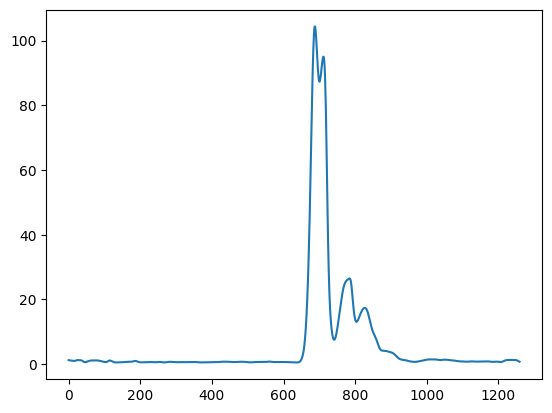

In [25]:
# First we need to do PoI selection
snr_prof = snr(sbox[pt_prof[:,attack_byte]^key_prof[:,attack_byte]], traces_prof)
plt.plot(snr_prof)

# just take a window of 30 around the point of maximum leakage
window = (np.argmax(snr_prof)- 20, np.argmax(snr_prof) + 20)

In [26]:
traces_hw = np.array([traces_prof[HW[sbox[pt_prof[:, attack_byte] ^ key_prof[:,attack_byte]]] == hw, window[0]:window[1]] for hw in range(9)], dtype=object)
for hw in range(9):
    print(f"traces with hw {hw}: {traces_hw[hw].shape[0]}")

traces with hw 0: 382
traces with hw 1: 3093
traces with hw 2: 10827
traces with hw 3: 21882
traces with hw 4: 27480
traces with hw 5: 21855
traces with hw 6: 10921
traces with hw 7: 3164
traces with hw 8: 396


In [27]:
mean_mat = np.array([np.mean(traces_hw[hw], axis=0) for hw in range(9)])
cov_mat = np.array([np.cov(traces_hw[hw], rowvar=False) for hw in range(9)])

In [28]:
# we have built a multivariate normal distribution for each HW based on the profiling dataset, i.e. we have our model
# we can now run the attack on the attack dataset
key_vector = np.zeros(256)

# note: we only need to use 10 traces in our attack now
for i in tqdm(range(10)):
    for kguess in range(256):
        hypothesis = HW[sbox[pt_attack[i, attack_byte] ^ kguess]]
        distr = multivariate_normal(mean=mean_mat[hypothesis], cov=cov_mat[hypothesis])
        p_k = distr.pdf(traces_attack[i, window[0]:window[1]])
        key_vector[kguess] += np.log(p_k)
        
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {key_attack[0][attack_byte]}")

  0%|          | 0/10 [00:00<?, ?it/s]

key hypothesis with highest log-likelihood: 186, correct key: 186


# Using ML for SCA
We will now look at a protected implementation. Specifically, the implementation is masked.

In [29]:
attack_byte = 0

In [30]:
with h5py.File('AES_PTv2_Pinata.h5', "r") as in_file:
    traces_prof = np.array(in_file["Pinata/MS1/Profiling/Traces"])
    traces_attack = np.array(in_file["Pinata/MS1/Attack/Traces"])
    
    pt_prof = np.array(in_file["Pinata/MS1/Profiling/MetaData"]['plaintext'])
    pt_attack = np.array(in_file["Pinata/MS1/Attack/MetaData"]['plaintext'])
    
    key_prof = np.array(in_file["Pinata/MS1/Profiling/MetaData"]['key'])
    key_attack = np.array(in_file["Pinata/MS1/Attack/MetaData"]['key'])
print(traces_prof.shape)
print(len(np.unique(traces_prof)))

(150000, 1500)
1375


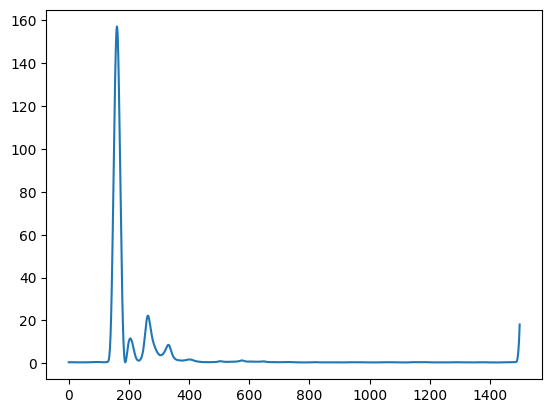

In [31]:
# the implementation is masked, but is it done correctly?
plt.plot(snr(sbox[pt_prof[:,attack_byte] ^ key_prof[:,attack_byte]], traces_prof))

In [32]:
import tensorflow as tf
from keras import layers
from keras.utils import to_categorical
import tensorflow_addons as tfa

with tf.device("GPU"):
    start = layers.Input(shape=(1500, 1))

    # Convolution layer
    x = layers.Conv1D(8, 16, kernel_initializer='he_uniform',
                      activation='selu', padding='same')(start)
    x = layers.MaxPool1D(2, strides=2)(x)
    x = layers.BatchNormalization()(x)

    # Flatten for dense layers
    x = layers.Flatten()(x)

    # Dense layers
    x = layers.Dense(400, kernel_initializer='he_uniform',
                     activation='selu')(x)

    x = layers.Dense(50, kernel_initializer='he_uniform',
                    activation='selu')(x)
    
    # Classification layer
    end = layers.Dense(9, activation='softmax',
                       name='predictions')(x)

    clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
        maximal_learning_rate=1e-2,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * traces_prof.shape[0]
    )

    model = tf.keras.models.Model(start, end)
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(clr),
                  metrics=['accuracy'])

/Users/filippocasari/Dropbox/Mac/Downloads/AS3SecurityML/.conda/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
2023-06-04 16:44:36.102558: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-04 16:44:36.102588: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memo

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



/Users/filippocasari/Dropbox/Mac/Downloads/AS3SecurityML/.conda/lib/python3.9/site-packages/keras/src/saving/serialization_lib.py:394: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized:         scale_fn=lambda x: 1/(2.**(x-1)),

  return {key: serialize_keras_object(value) for key, value in obj.items()}


In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [34]:
tf.debugging.set_log_device_placement(True)
with tf.device('GPU'):
    model.fit(x=traces_prof, y=to_categorical(HW[sbox[pt_prof[:, attack_byte] ^ key_prof[:, attack_byte]]]),
                  batch_size=50, verbose=1,
                  epochs=40,
                  shuffle=True,
                  callbacks=[early_stopping],
                  validation_split=0.2,
             )

Epoch 1/40


2023-06-04 16:44:59.738617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2400/2400 [==============================] - ETA: 0s - loss: 1.3480 - accuracy: 0.4268

2023-06-04 16:48:07.729200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2400/2400 [==============================] - 217s 89ms/step - loss: 1.3480 - accuracy: 0.4268 - val_loss: 1.0598 - val_accuracy: 0.4940
Epoch 2/40
2400/2400 [==============================] - 211s 88ms/step - loss: 0.8296 - accuracy: 0.6390 - val_loss: 0.6218 - val_accuracy: 0.7432
Epoch 3/40
2400/2400 [==============================] - 217s 91ms/step - loss: 0.6540 - accuracy: 0.7231 - val_loss: 0.7154 - val_accuracy: 0.6938
Epoch 4/40
2400/2400 [==============================] - 73s 30ms/step - loss: 0.5732 - accuracy: 0.7615 - val_loss: 0.5665 - val_accuracy: 0.7632
Epoch 5/40
2400/2400 [==============================] - 68s 29ms/step - loss: 0.5187 - accuracy: 0.7856 - val_loss: 0.4583 - val_accuracy: 0.8092
Epoch 6/40
2400/2400 [==============================] - 68s 28ms/step - loss: 0.5023 - accuracy: 0.7934 - val_loss: 0.4235 - val_accuracy: 0.8296
Epoch 7/40
2400/2400 [==============================] - 69s 29ms/step - loss: 0.4721 - accuracy: 0.8080 - val_loss: 0.5290 - val_acc

# predict probabilities and calculate log


In [35]:
predictions = model.predict(traces_attack)
predictions = np.log(predictions + 1e-20)
key_vector = np.zeros(256)

for i in tqdm(range(10)):
    for kguess in range(256):
        hypothesis = HW[sbox[pt_attack[i, attack_byte] ^ kguess]]
        key_vector[kguess] += predictions[i, hypothesis]
        
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {key_attack[0][attack_byte]}")

  16/1563 [..............................] - ETA: 11s

2023-06-04 17:14:23.790750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 10s 7ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

key hypothesis with highest log-likelihood: 202, correct key: 202


In [36]:
def random_subset(size, *a):
    """
    Takes a random subset of size :size: from the given arrays. Makes sure that the rows of the arrays still match after shuffling.
    Example usage: subset_train, subset_labels = random_subset(10, training_set, training_labels)

    :size: size of the subset
    :*a: arrays to take subset of
    """
    combined = list(zip(*a))
    random.shuffle(combined)
    b = [np.array(i)[:size] for i in zip(*combined)]

    return b

def ge_sr(traces, plaintext, key, byte, model, success_cutoff, nr_attack_traces, averaging_nr, track=False, data_augment=None):
    """
    Returns (guessing entropy, success rate) tuple of the given model over the given traces

    :traces: all available attacking traces
    :plaintext: all corresponding plaintext
    :key: the real key
    :byte: byte of key to attack
    :model: model used for making predictions
    :success_cutoff: cutoff to calculate success rate (key rank < success_cutoff)
    :nr_attack_traces: number of traces to use for attacking
    :averaging_nr: number of times to perform attack on subtraces in order to calculate the guessing entropy and success rate
    :track: boolean to indicate whether the guessing entropy should be tracked for each trace amount up to :nr_attack_traces:
    :data_augment: Default None. If not None, should be a function which takes traces as input and returns the augmented traces.
    """

    if track:
        key_ranks = np.zeros((averaging_nr, nr_attack_traces))
        successes = np.zeros((averaging_nr, nr_attack_traces))
    else:
        key_ranks = np.zeros((averaging_nr))
        successes = np.zeros((averaging_nr))

    for run in tqdm(range(averaging_nr), desc="run", leave=False):
        # take a random subset from the attacking traces
        attack_traces, attack_plaintext = random_subset(
            nr_attack_traces, traces, plaintext)

        if data_augment:
            print(f"applying data augmentation")
            attack_traces = data_augment(attack_traces)
        
        # make predictions: probability of each label, where label = sbox[plt[byte] ^ key[byte]]
        predictions = model(attack_traces, training=False)

        # convert probability to log values
        predictions = np.log(predictions+1e-20)
        _, leakage_mdl = predictions.shape
            
        # set the key probabilities to 0 for each key hypothesis
        key_probabilities = np.zeros(256)

        # for each trace, add up the log(probability) of each key hypothesis
        for i in tqdm(range(nr_attack_traces), desc='attack', leave=False):
            for k in range(256):
                if leakage_mdl == 9:
                    key_probabilities[k] += predictions[i, HW[sbox[attack_plaintext[i, byte] ^ k]]]
                else:
                    key_probabilities[k] += predictions[i, sbox[attack_plaintext[i, byte] ^ k]]

            # if tracking per trace, then add to key_ranks and successes array here
            if track:
                # now key_probabilities contains estimated key probability after i traces
                key_rank = list(np.argsort(key_probabilities)
                                [::-1]).index(key[byte])
                success = int(key_rank < success_cutoff)

                key_ranks[run, i] = key_rank
                successes[run, i] = success

        # if not tracking per trace, only add to key_ranks and successes array after all traces are attacked
        if not track:
            # now key_probabilities contains the estimated key probability of each key after the full attack
            # argsort()[::-1] -> sorts key values from most likely to least likely. Then get index of actual key byte to get the key rank.
            key_rank = list(np.argsort(key_probabilities)
                            [::-1]).index(key[byte])

            success = int(key_rank < success_cutoff)

            key_ranks[run] = key_rank
            successes[run] = success

    return np.mean(key_ranks, axis=0), np.mean(successes, axis=0)

In [37]:
ge, sr = ge_sr(traces_attack, pt_attack, key_attack[0], byte=attack_byte, model=model, success_cutoff=1,nr_attack_traces=10,averaging_nr=100, track=True)

run:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

[]

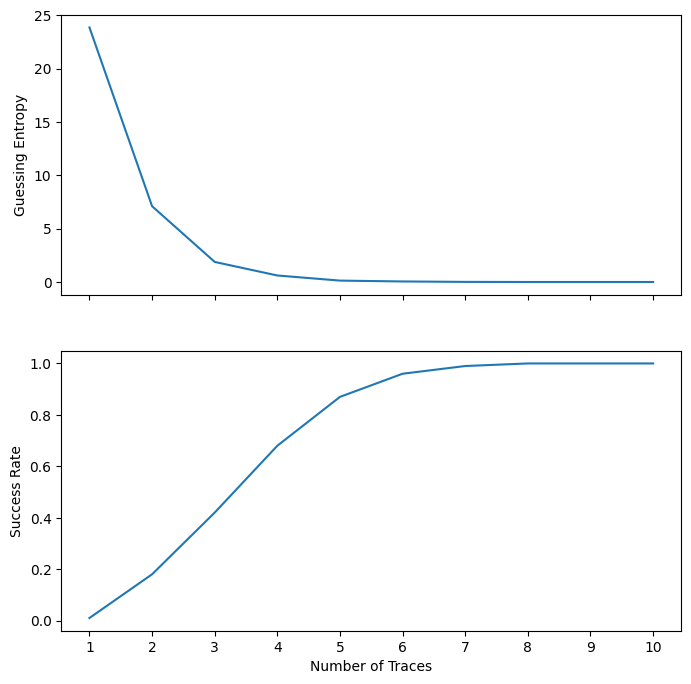

In [38]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].plot(range(1, len(ge)+1), ge)
axs[0].set_ylabel("Guessing Entropy")
axs[1].plot(range(1, len(sr)+1), sr)
axs[1].set_ylabel("Success Rate")
axs[1].set_xlabel("Number of Traces")
axs[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
axs[1].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.plot()

In [43]:
print(to_categorical(sbox[pt_prof[:, attack_byte] ^ key_prof[:, attack_byte]]).shape)
print(to_categorical(HW[sbox[pt_prof[:, attack_byte] ^ key_prof[:, attack_byte]]]).shape)

(150000, 256)
(150000, 9)


### exercise: rewrite the code (you can copy and paste it below if you want to preserve the original) to be in the ID leakage model

In [45]:
# exercise: rewrite the code (you can copy and paste it below if you want to preserve the original) to be in the ID leakage model
with tf.device("GPU"):
    start = layers.Input(shape=(1500, 1))

    # Convolution layer
    x = layers.Conv1D(8, 16, kernel_initializer='he_uniform',
                      activation='selu', padding='same')(start)
    x = layers.MaxPool1D(2, strides=2)(x)
    x = layers.BatchNormalization()(x)

    # Flatten for dense layers
    x = layers.Flatten()(x)

    # Dense layers
    x = layers.Dense(400, kernel_initializer='he_uniform',
                     activation='selu')(x)

    x = layers.Dense(50, kernel_initializer='he_uniform',
                    activation='selu')(x)
    
    # Classification layer
    # now 256 outputs: keys
    end = layers.Dense(256, activation='softmax',
                       name='predictions')(x)

    clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-5,
        maximal_learning_rate=1e-2,
        scale_fn=lambda x: 1/(2.**(x-1)),
        step_size=2 * traces_prof.shape[0]
    )

    model = tf.keras.models.Model(start, end)
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(clr),
                  metrics=['accuracy'])
tf.debugging.set_log_device_placement(True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
with tf.device('GPU'):
    model.fit(x=traces_prof, y=to_categorical(sbox[pt_prof[:, attack_byte] ^ key_prof[:, attack_byte]]),
                  batch_size=50, verbose=1,
                  epochs=40,
                  shuffle=True,
                  callbacks=[early_stopping],
                  validation_split=0.2,
             )


Epoch 1/40


2023-06-04 17:22:24.913452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2399/2400 [============================>.] - ETA: 0s - loss: 5.6251 - accuracy: 0.0045

2023-06-04 17:23:24.999442: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2400/2400 [==============================] - 68s 28ms/step - loss: 5.6251 - accuracy: 0.0045 - val_loss: 5.6039 - val_accuracy: 0.0066
Epoch 2/40
2400/2400 [==============================] - 67s 28ms/step - loss: 5.2981 - accuracy: 0.0114 - val_loss: 4.9111 - val_accuracy: 0.0187
Epoch 3/40
2400/2400 [==============================] - 63s 26ms/step - loss: 4.7204 - accuracy: 0.0214 - val_loss: 4.5581 - val_accuracy: 0.0243
Epoch 4/40
2400/2400 [==============================] - 63s 26ms/step - loss: 4.5149 - accuracy: 0.0254 - val_loss: 5.1127 - val_accuracy: 0.0132
Epoch 5/40
2400/2400 [==============================] - 63s 26ms/step - loss: 4.4316 - accuracy: 0.0269 - val_loss: 4.3709 - val_accuracy: 0.0252
Epoch 6/40
2400/2400 [==============================] - 64s 27ms/step - loss: 4.3801 - accuracy: 0.0278 - val_loss: 4.2818 - val_accuracy: 0.0287
Epoch 7/40
2400/2400 [==============================] - 64s 27ms/step - loss: 4.3375 - accuracy: 0.0290 - val_loss: 4.3030 - val_accura

In [46]:
predictions = model.predict(traces_attack)
predictions = np.log(predictions + 1e-20)
key_vector = np.zeros(256)

for i in tqdm(range(10)):
    for kguess in range(256):
        hypothesis = sbox[pt_attack[i, attack_byte] ^ kguess]
        key_vector[kguess] += predictions[i, hypothesis]
        
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {key_attack[0][attack_byte]}")

   6/1563 [..............................] - ETA: 16s 

2023-06-04 17:47:23.060426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 11s 7ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

key hypothesis with highest log-likelihood: 202, correct key: 202


In [47]:
ge, sr = ge_sr(traces_attack, pt_attack, key_attack[0], byte=attack_byte, model=model, success_cutoff=1,nr_attack_traces=10,averaging_nr=100, track=True)

run:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

attack:   0%|          | 0/10 [00:00<?, ?it/s]

[]

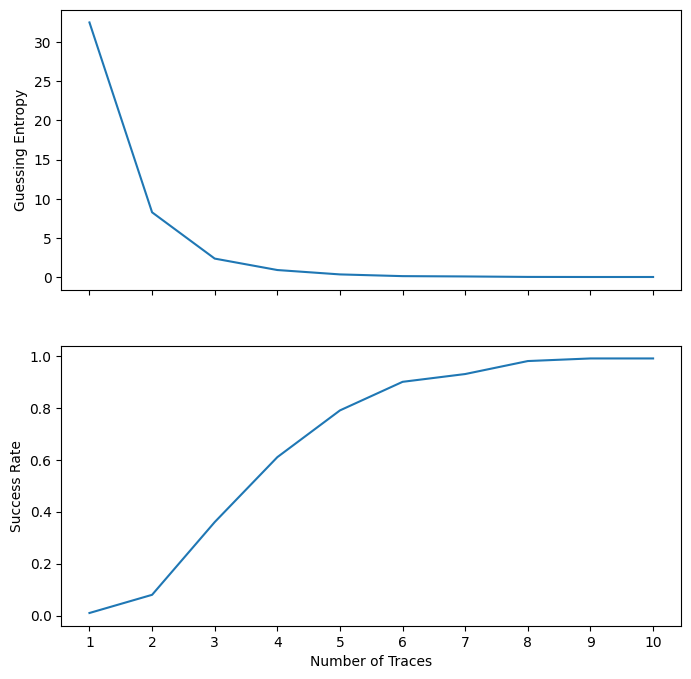

In [48]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].plot(range(1, len(ge)+1), ge)
axs[0].set_ylabel("Guessing Entropy")
axs[1].plot(range(1, len(sr)+1), sr)
axs[1].set_ylabel("Success Rate")
axs[1].set_xlabel("Number of Traces")
axs[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
axs[1].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))
plt.plot()

# ASCAD dataset

In [50]:
def read_data(file_loc, raw=False):
    """
    Reads in the ASCAD h5 dataset from the given dir_loc. If raw = False, reads ASCAD.h5 and assumes the simplified dataset structure.
    If raw = True, reads ATMega8515_raw_traces.h5 and assumes the raw traces dataset structure. 
    Returns the tuple: (x_train, x_test, plt_train, plt_test, keys_train, keys_test)
    :dir_loc: directory where the ASCAD dataset is located. Default = 'F:\\ASCAD\\ATMEGA_AES_v1\\ATM_AES_v1_fixed_key\\ASCAD_data\\ASCAD_databases\\'
    :data_name: Dataset name. Default = 'ASCAD.h5'
    """
    with h5py.File(file_loc, "r") as in_file:
        # Load traces
        x_train = np.array(
            in_file['Profiling_traces/traces'], dtype=np.int8)
        x_test = np.array(in_file['Attack_traces/traces'], dtype=np.int8)
        # labels are sbox(plt[2] XOR key[2])
        
        labels_train = np.array(in_file['Profiling_traces/labels'])
        labels_test = np.array(in_file['Attack_traces/labels'])
        
        plt_train = np.array(
            in_file['Profiling_traces/metadata']['plaintext'])
        plt_test = np.array(in_file['Attack_traces/metadata']['plaintext'])

        keys_train = np.array(in_file['Profiling_traces/metadata']['key'])
        keys_test = np.array(in_file['Attack_traces/metadata']['key'])
        
        masks_train = np.array(in_file['Profiling_traces/metadata']['masks'])
        masks_test = np.array(in_file['Attack_traces/metadata']['masks'])
        
        return x_train, x_test, labels_train, labels_test, plt_train, plt_test, keys_train, keys_test, masks_train, masks_test

In [51]:
# load in data
# this dataset is synchronized, try to build a model to perform an attack!
import keras
import keras.layers as layers
x_train, x_test, labels_train, labels_test, plt_train, plt_test, keys_train, keys_test, masks_train, masks_test = read_data('Base_desync0.h5')


The 14 first elements of the mask array correspond to the masks r[3],··· ,r[16] in Algorithm 1 and the two last elements respectively correspond to r_in and r_out (the masks r [1] and r[2] have been forced to 0 for test/validation purpose)

You can find information about the dataset in the corresponding paper [here](https://link.springer.com/article/10.1007/s13389-019-00220-8)

In [52]:
# labels here are the output of the sbox of byte 2, i.e.
attack_byte = 2

np.all(sbox[plt_train[:,attack_byte] ^ keys_train[:,attack_byte]] == labels_train)

True

(50000, 700)
(50000, 16)
(50000, 16)


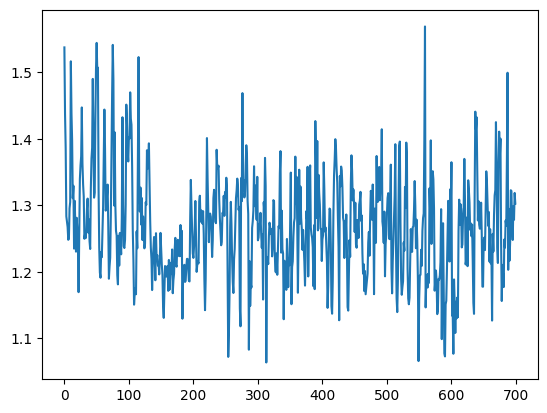

In [53]:
print(x_train.shape)
print(masks_train.shape)
print(plt_train.shape)
plt.plot(snr(sbox[plt_train[:,attack_byte] ^ keys_train[:,attack_byte]],x_train))

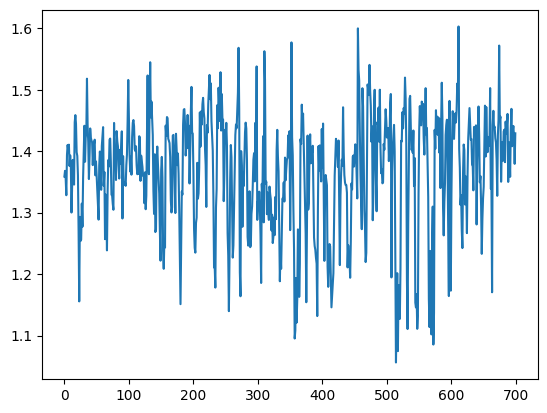

In [54]:
# it doesn't seem like the sbox output leaks..
# exercise: check if the masks leak
plt.plot(snr(masks_train[:,attack_byte],x_train))


In [ ]:
# exercise: break the ASCAD dataset! You can use any kind of model, preprocessing, etc. you like, but keep the profiling - attack seperation

In [ ]:
# exercise: validate you can break the ASCAD dataset
# calculate the guessing entropy and the success rate when using the attack / test traces

# USING MPL best
Implementation from paper: https://eprint.iacr.org/2018/053.pdf

In [57]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, AveragePooling1D, BatchNormalization, Activation, Add, add, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input
#from tensorflow.keras.optimizers.legacy import RMSprop, Adam
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
import sys
class myCNN:
    
    def __init__(self, name="CNN"):
        self.name = name
        
    def mlp_best(self, node=200,layer_nb=6,input_dim=700):
        model = Sequential()
        model.add(Dense(node, input_dim=input_dim, activation='relu'))
        #model.add(Dropout(0.4))
        for i in range(layer_nb-2):
            model.add(Dense(node, activation='relu'))
        #model.add(Dropout(0.4))
        model.add(Dense(256, activation='softmax'))
        optimizer = RMSprop(lr=0.00001)
        #optimizer=Adam(lr=0.00001)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        return model
    

def train_model(X_profiling, Y_profiling, model, save_file_name, epochs=150, batch_size=100, multilabel=0, validation_split=0, early_stopping=0):
    #check_file_exists(os.path.dirname(save_file_name))
    # Save model calllback
    save_model = ModelCheckpoint(save_file_name)
    callbacks=[save_model]
    # Early stopping callback
    if (early_stopping != 0):
        if validation_split == 0:
            validation_split=0.1
        callbacks.append(EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True))
    # Get the input layer shape
    if isinstance(model.get_layer(index=0).input_shape, list):
        input_layer_shape = model.get_layer(index=0).input_shape[0]
    else:
        input_layer_shape = model.get_layer(index=0).input_shape
    # Sanity check
    if input_layer_shape[1] != len(X_profiling[0]):
        print("Error: model input shape %d instead of %d is not expected ..." % (input_layer_shape[1], len(X_profiling[0])))
        sys.exit(-1)
    # Adapt the data shape according our model input
    if len(input_layer_shape) == 2:
        # This is a MLP
        Reshaped_X_profiling = X_profiling
    elif len(input_layer_shape) == 3:
        # This is a CNN: expand the dimensions
        Reshaped_X_profiling = X_profiling.reshape((X_profiling.shape[0], X_profiling.shape[1], 1))
    else:
        print("Error: model input shape length %d is not expected ..." % len(input_layer_shape))
        sys.exit(-1)
    #print(f"shape Reshaped X: {Reshaped_X_profiling.shape}")
    y=to_categorical(Y_profiling, num_classes=256)
    #y = tf.keras.utils.to_categorical(Y_profiling, num_classes=256)
    
    history = model.fit(x=Reshaped_X_profiling, y=y, batch_size=batch_size, verbose = 1, validation_split=validation_split, epochs=epochs, callbacks=callbacks)
    return history

# Preprocessing
I used PCA to tranform from a space of 700 features to 100 features

In [62]:
from sklearn.decomposition import PCA
pca =PCA(n_components=100)
X_train = pca.fit_transform(x_train)
MPL = myCNN().mlp_best(input_dim=100)
tf.config.list_physical_devices('GPU')


with tf.device('GPU'):
    history =train_model(X_train, labels_train, MPL, "mlp2", batch_size=100, epochs=200, validation_split=0.1, early_stopping=1)


Epoch 1/200


2023-06-04 17:57:31.809655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


447/450 [============================>.] - ETA: 0s - loss: 5.5541 - accuracy: 0.0040

2023-06-04 17:57:39.810058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 9s 18ms/step - loss: 5.5540 - accuracy: 0.0040 - val_loss: 5.5468 - val_accuracy: 0.0034
Epoch 2/200
448/450 [============================>.] - ETA: 0s - loss: 5.5454 - accuracy: 0.0046INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 18ms/step - loss: 5.5454 - accuracy: 0.0046 - val_loss: 5.5449 - val_accuracy: 0.0050
Epoch 3/200
449/450 [============================>.] - ETA: 0s - loss: 5.5220 - accuracy: 0.0057INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 17ms/step - loss: 5.5220 - accuracy: 0.0057 - val_loss: 5.4852 - val_accuracy: 0.0052
Epoch 4/200
447/450 [============================>.] - ETA: 0s - loss: 5.4271 - accuracy: 0.0074INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 7s 17ms/step - loss: 5.4271 - accuracy: 0.0074 - val_loss: 5.4163 - val_accuracy: 0.0052
Epoch 5/200
450/450 [==============================] - ETA: 0s - loss: 5.3450 - accuracy: 0.0106INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 17ms/step - loss: 5.3450 - accuracy: 0.0106 - val_loss: 5.3829 - val_accuracy: 0.0076
Epoch 6/200
448/450 [============================>.] - ETA: 0s - loss: 5.2843 - accuracy: 0.0117INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 18ms/step - loss: 5.2844 - accuracy: 0.0116 - val_loss: 5.3694 - val_accuracy: 0.0092
Epoch 7/200
449/450 [============================>.] - ETA: 0s - loss: 5.2351 - accuracy: 0.0145INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 17ms/step - loss: 5.2350 - accuracy: 0.0144 - val_loss: 5.3696 - val_accuracy: 0.0088
Epoch 8/200
447/450 [============================>.] - ETA: 0s - loss: 5.1881 - accuracy: 0.0161INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 18ms/step - loss: 5.1878 - accuracy: 0.0160 - val_loss: 5.3920 - val_accuracy: 0.0066
Epoch 9/200
447/450 [============================>.] - ETA: 0s - loss: 5.1393 - accuracy: 0.0194INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 18ms/step - loss: 5.1395 - accuracy: 0.0193 - val_loss: 5.4194 - val_accuracy: 0.0082
Epoch 10/200
449/450 [============================>.] - ETA: 0s - loss: 5.0871 - accuracy: 0.0234INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 18ms/step - loss: 5.0871 - accuracy: 0.0234 - val_loss: 5.4411 - val_accuracy: 0.0082
Epoch 11/200
450/450 [==============================] - ETA: 0s - loss: 5.0284 - accuracy: 0.0277INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 18ms/step - loss: 5.0284 - accuracy: 0.0277 - val_loss: 5.5463 - val_accuracy: 0.0058
Epoch 12/200
450/450 [==============================] - ETA: 0s - loss: 4.9681 - accuracy: 0.0312INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 17ms/step - loss: 4.9681 - accuracy: 0.0312 - val_loss: 5.5712 - val_accuracy: 0.0076
Epoch 13/200
449/450 [============================>.] - ETA: 0s - loss: 4.9056 - accuracy: 0.0355INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 18ms/step - loss: 4.9054 - accuracy: 0.0355 - val_loss: 5.6185 - val_accuracy: 0.0068
Epoch 14/200
447/450 [============================>.] - ETA: 0s - loss: 4.8329 - accuracy: 0.0427INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 18ms/step - loss: 4.8334 - accuracy: 0.0427 - val_loss: 5.6640 - val_accuracy: 0.0078
Epoch 15/200
449/450 [============================>.] - ETA: 0s - loss: 4.7598 - accuracy: 0.0496INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 9s 19ms/step - loss: 4.7601 - accuracy: 0.0495 - val_loss: 5.7551 - val_accuracy: 0.0064
Epoch 16/200
449/450 [============================>.] - ETA: 0s - loss: 4.6842 - accuracy: 0.0564INFO:tensorflow:Assets written to: mlp2/assets


INFO:tensorflow:Assets written to: mlp2/assets


450/450 [==============================] - 8s 18ms/step - loss: 4.6848 - accuracy: 0.0565 - val_loss: 5.8123 - val_accuracy: 0.0066


In [63]:
X_test = pca.transform(x_test)
predictions = MPL.predict(X_test)
predictions = np.log(predictions + 1e-20)

 65/313 [=====>........................] - ETA: 0s

2023-06-04 17:59:46.067424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


In [68]:
import itertools
key_vector = np.zeros(256)

for i, kguess in itertools.product((range(10)), range(256)):
    hypothesis = sbox[plt_test[i, attack_byte] ^ kguess]
    key_vector[kguess] += predictions[i, hypothesis]
print(np.argsort(key_vector))
index = len(key_vector) - np.where(np.argsort(key_vector)==keys_test[0][attack_byte])[0][0]
print(f"position of the key {index} over {len(key_vector)} positions")
print(f"key hypothesis with highest log-likelihood: {np.argmax(key_vector)}, correct key: {keys_test[0][attack_byte]}")

[111  83 107 231  99 175 239 255  31 223 183 215 251 103 219  55  63 163
 123 207  43 127 243 227  27 119 235  39 155  91 211  35 191 179  23 167
 115 131  79 199 143  67  95 203  19 171  87  15  71  59  11 139 147   3
   7 247 195 151  51  47 187 159 135  97   9  61 189  75 185  85 101 125
 209 249  57 137  13 233 165  81 105 229 245 217  53 113  49 201 153 181
 177 169  41 145  73  33 197  77  21 121   1 193 225 157 141 253  37 173
  25 161 237  93 129  45   5  65  69 133  17  89 117 149 213 221  29 241
 205 109 118  62  38 226  54 130  74  58  78  34 218 250  66  10  82 138
 230 110 202 162 210 126  86  14 190 214 222 234 166 158 106 150 186 114
  90  50 246 242 134  42 170  70  46  18 178 142  30   2 154 182   6 102
 122  22 198 206  26  98 254 238 174 194 146  94 236 228 152 140  36  40
   8  12 156  48 224 220  28 252  84  88 164  96  32 212  92  72   0 120
  20 124  68 144  80 248 136 196 200  44 100 148 232 216  60 184 176 188
 180  56 244 112 240 104 168 208 192 172   4 132 12

In [78]:
ge, sr=ge_sr(X_test, plt_test, keys_test[0], attack_byte, MPL,success_cutoff=1,nr_attack_traces=100,averaging_nr=100, track=True)


run:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

attack:   0%|          | 0/100 [00:00<?, ?it/s]

[]

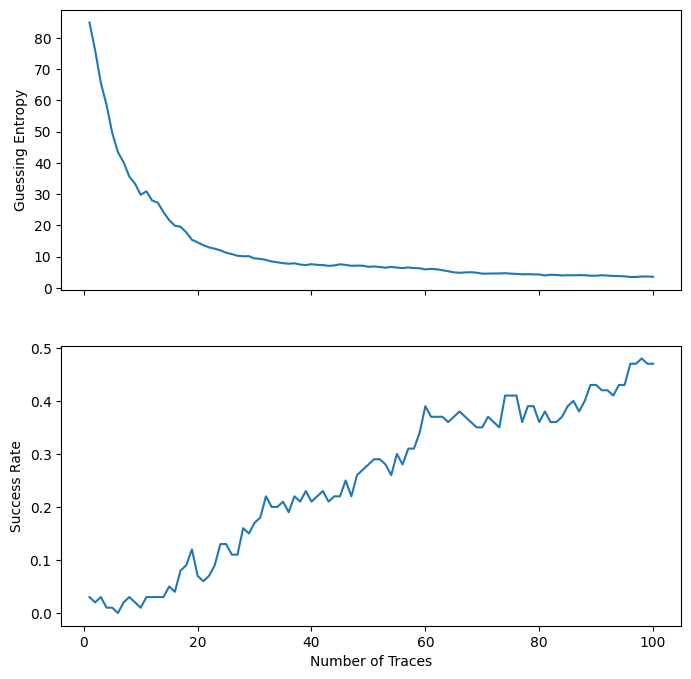

In [79]:
f, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
axs[0].plot(range(1, len(ge)+1), ge)
axs[0].set_ylabel("Guessing Entropy")
axs[1].plot(range(1, len(sr)+1), sr)
axs[1].set_ylabel("Success Rate")
axs[1].set_xlabel("Number of Traces")

#axs[1].xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
#axs[1].xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(1))

plt.plot()